This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [39]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

In [40]:
%matplotlib notebook

In [41]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments1'
imageroot = '20200624_case1.1'
Calibrationfile = '../case1.0 (calibration)/Calibration.nml'

/home/chemistry/repositories/ice2021/crystals/2020-06-24/Run 1/case1.1 (ablation roughening)
2020-06-24/Run 1/case1.1 (ablation roughening)


In [42]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments1_retrieved.npz
Segments1_roughness.jpg
Segments1_roughness.txt


In [43]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [44]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/20200624_case1.1-A.bmp
SEMimages/20200624_case1.1-B.bmp
SEMimages/20200624_case1.1-C.bmp
SEMimages/20200624_case1.1-D.bmp
Filename, dx and dy SEMimages/20200624_case1.1-D.bmp 0.6614583 0.6614583


In [45]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 8.927584191287348
Correlation of detectors A-D for each segment
for segment  0
nx= 36
ny= 36
0 1 15.944686622942609
0 2 -16.97059043970785
0 3 31.31068465664944
1 2 34.80652942480114
1 3 -52.2918191881396
2 3 13.358335251379197
Correlation score = 75.14630337107184



<IPython.core.display.Javascript object>


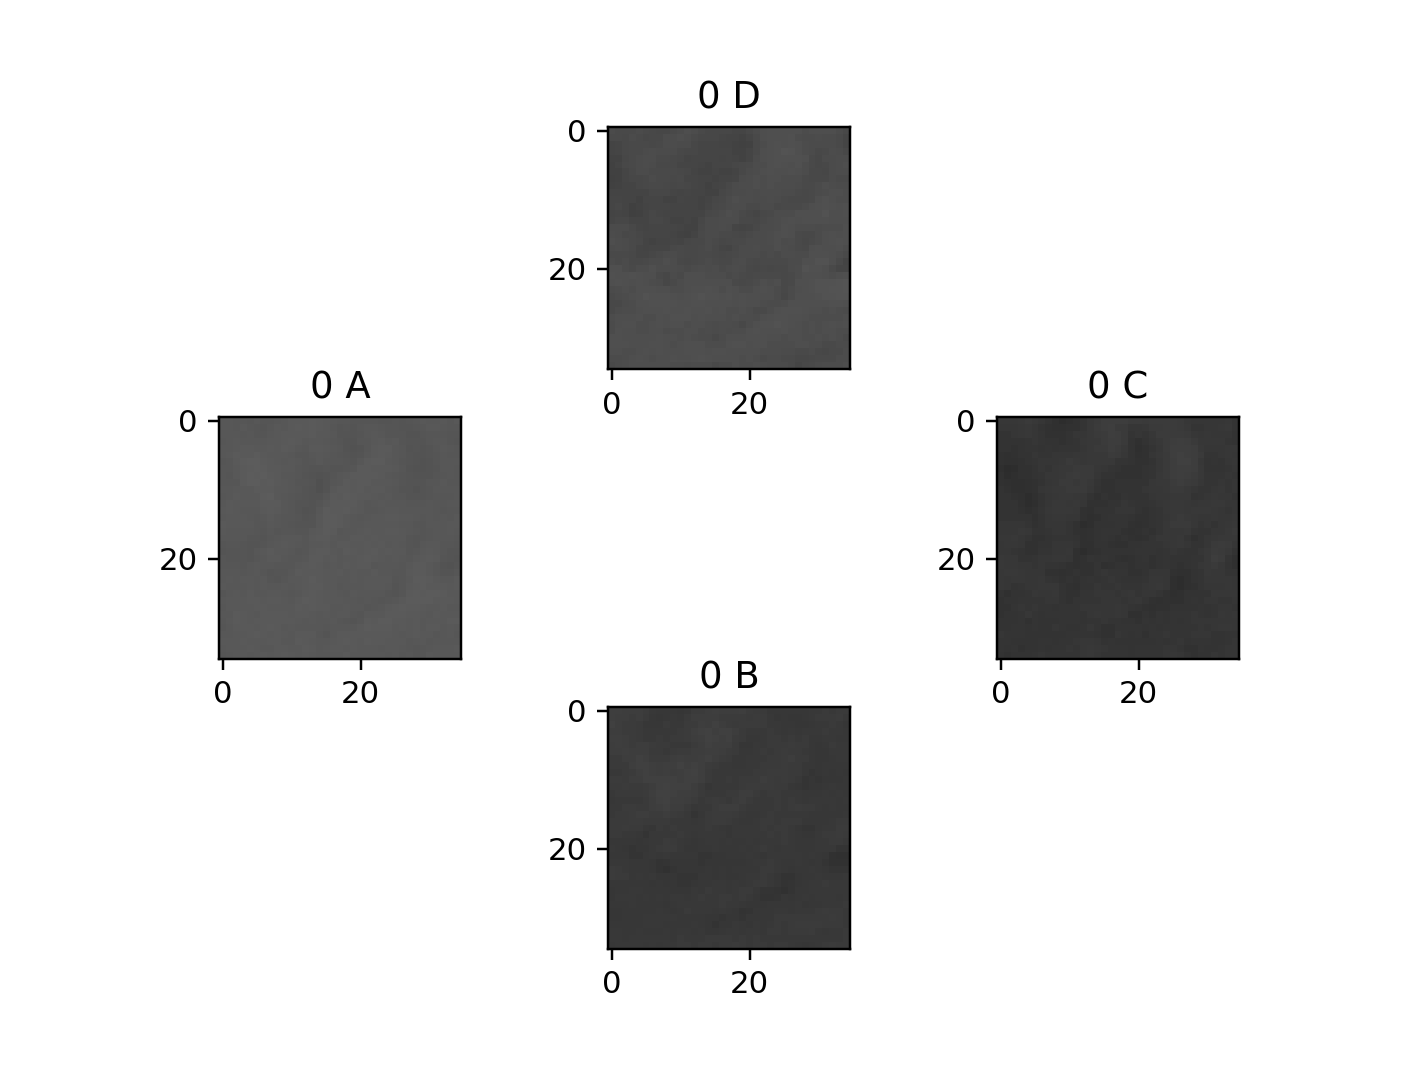

for segment  1
nx= 36
ny= 36
0 1 29.65464403535572
0 2 22.279247565604777
0 3 44.02057139598081
1 2 35.51703473314314
1 3 -16.783147829446865
2 3 41.88723430430157
Correlation score = 81.3095793615096



<IPython.core.display.Javascript object>


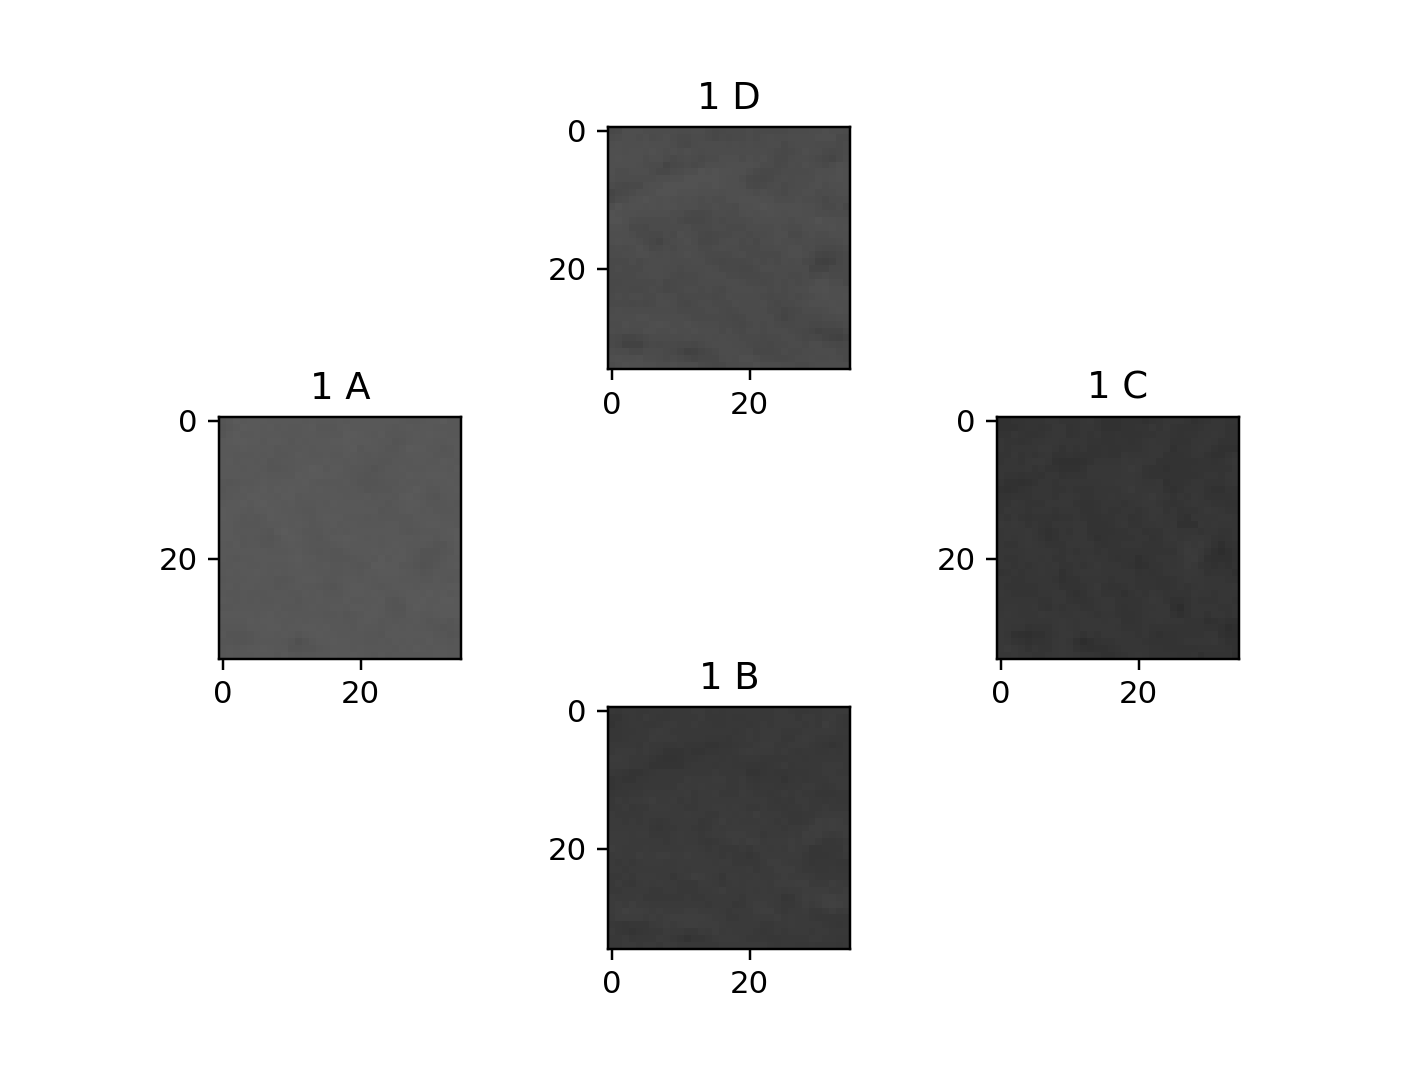

for segment  2
nx= 36
ny= 36
0 1 18.1017451418998
0 2 20.052331933758865
0 3 53.350854259456185
1 2 50.095853422713354
1 3 -21.55475464577271
2 3 20.191933966214393
Correlation score = 83.41462113240746



<IPython.core.display.Javascript object>


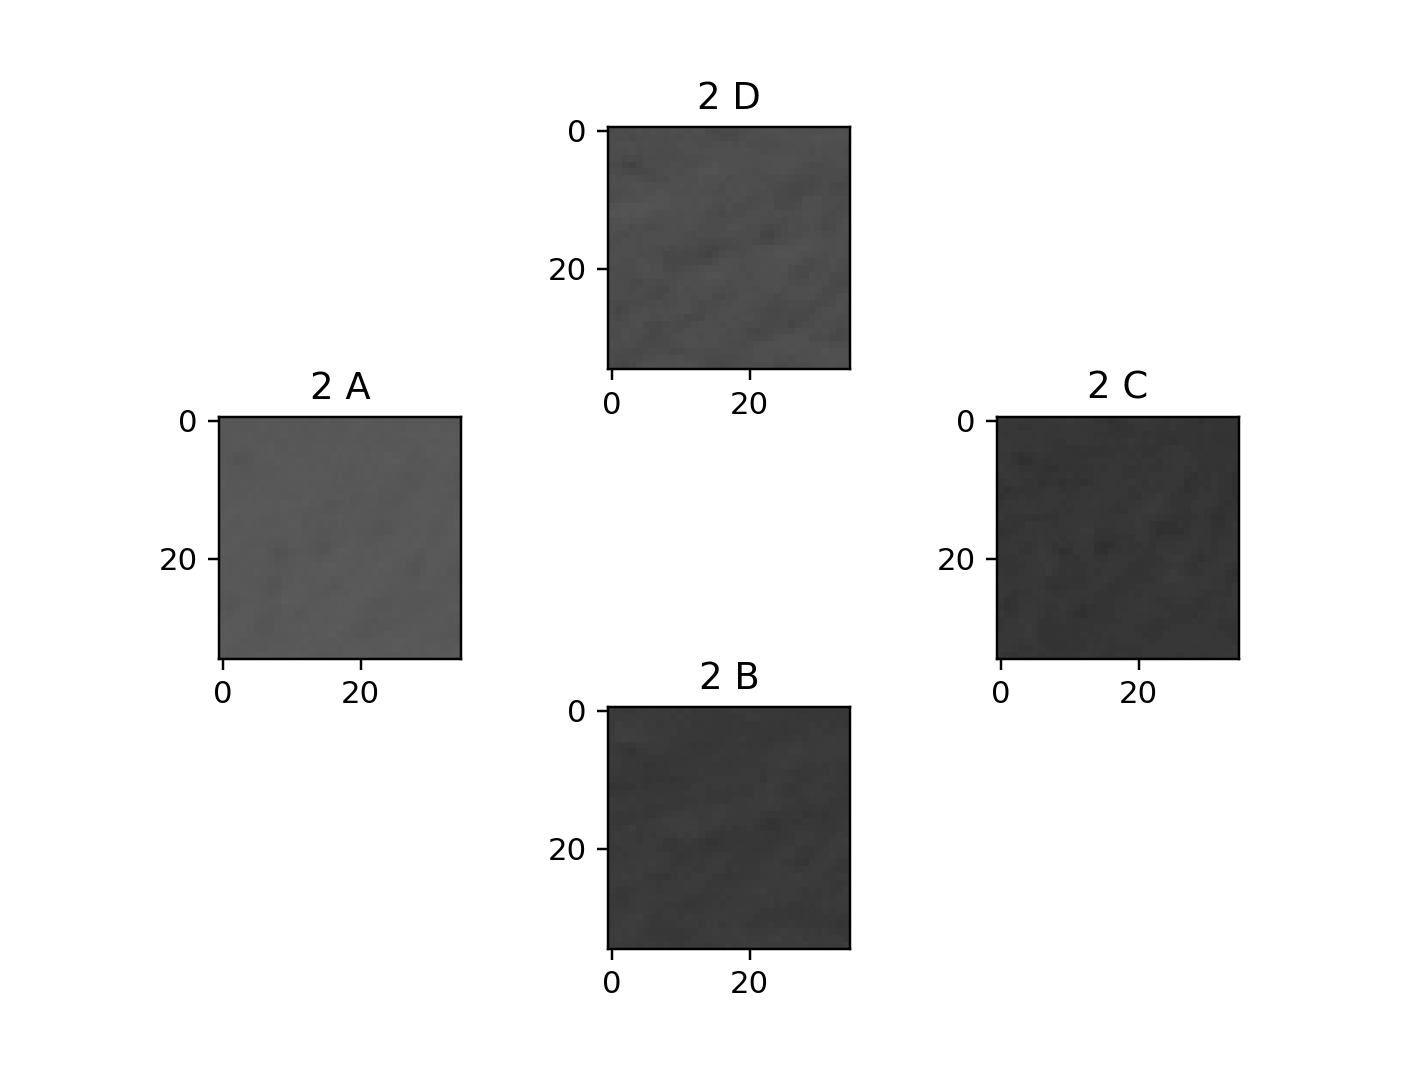

for segment  3
nx= 36
ny= 36
0 1 42.01744388767929
0 2 5.178040621244121
0 3 26.262730298947623
1 2 15.481191832123109
1 3 -8.901817314317663
2 3 43.96803170810181
Correlation score = 68.80484112771367



<IPython.core.display.Javascript object>


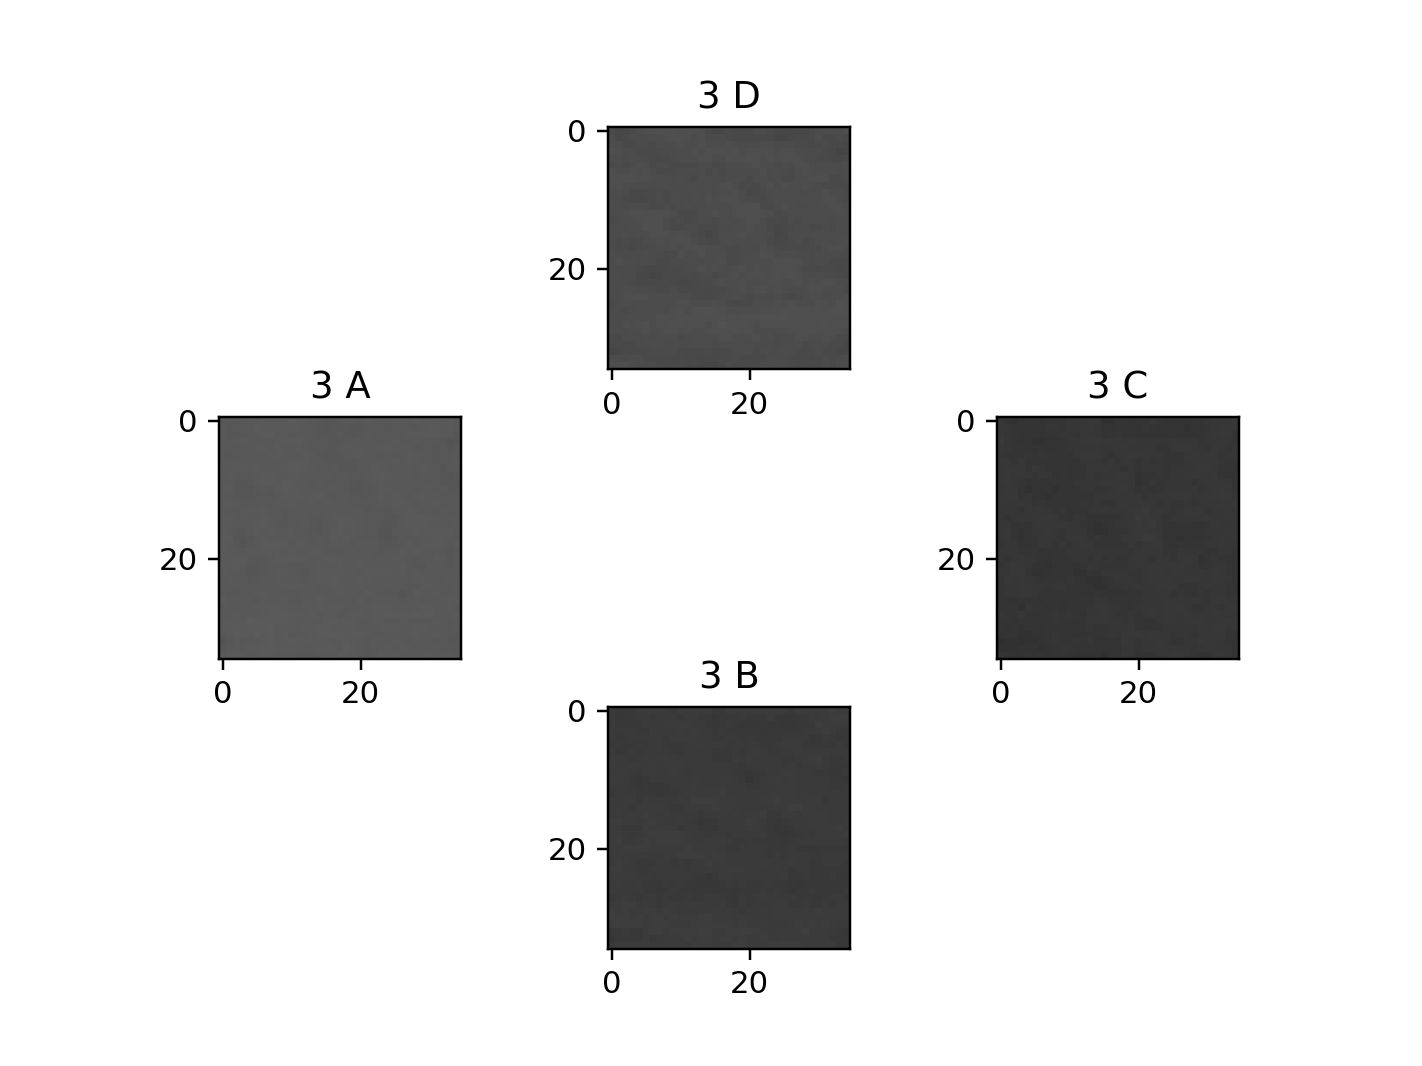

for segment  4
nx= 36
ny= 36
0 1 5.042321224064442
0 2 -18.038404520268227
0 3 50.89713974180607
1 2 48.34444859082559
1 3 -22.766145933622386
2 3 14.780945897930414
Correlation score = 77.55828354676201



<IPython.core.display.Javascript object>


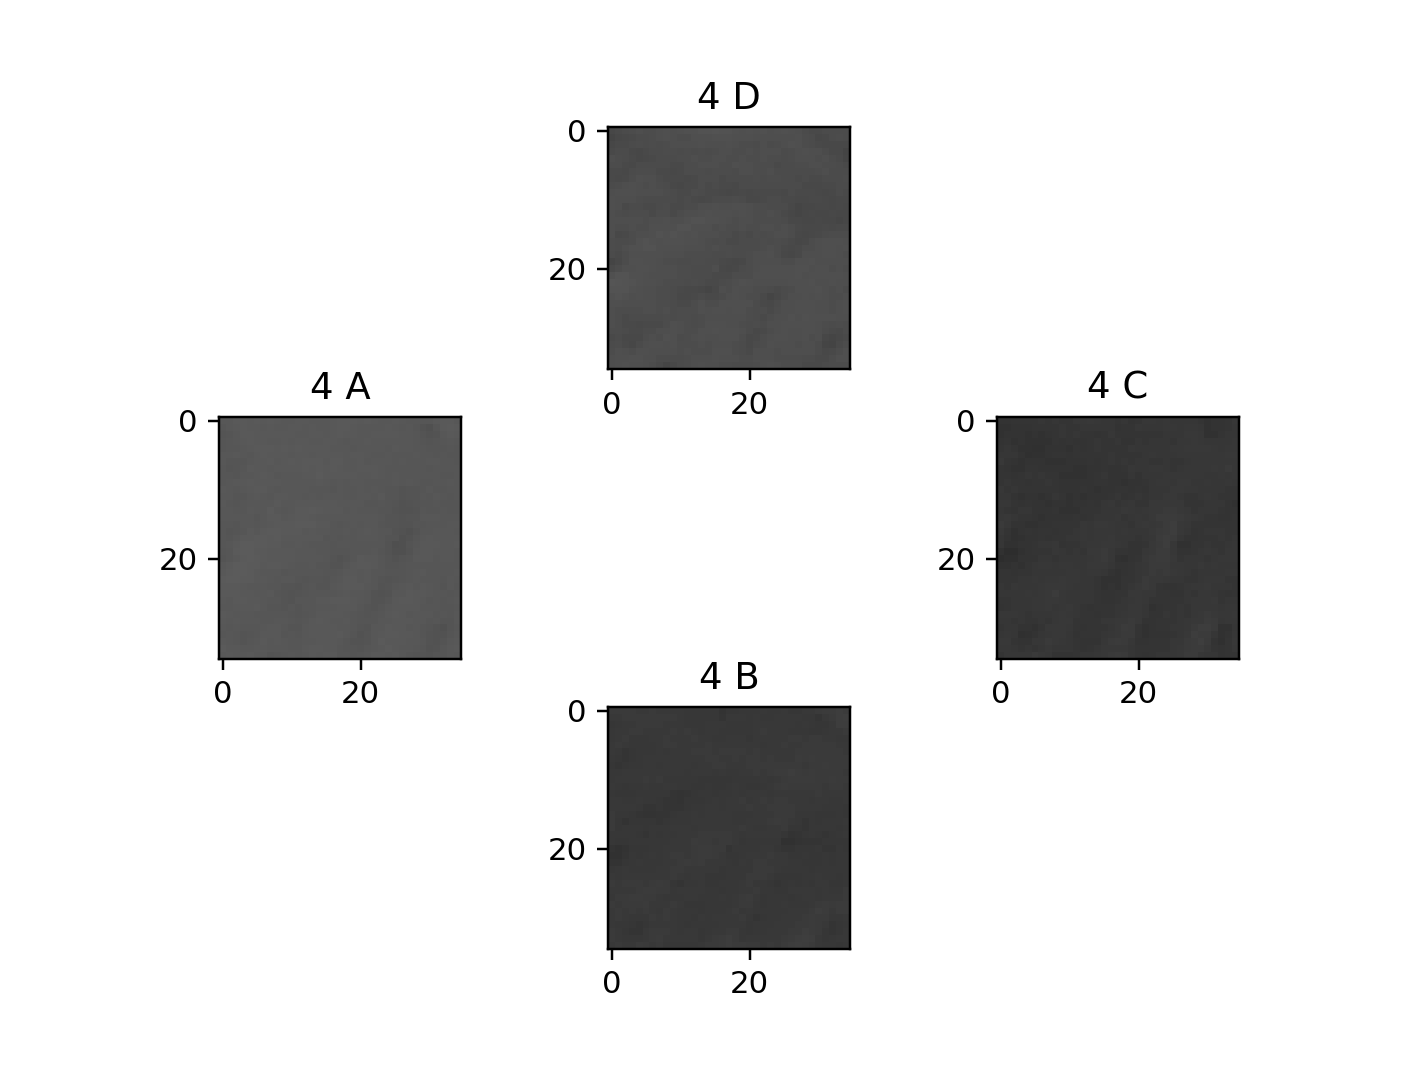

for segment  5
nx= 36
ny= 36
0 1 45.864062838117114
0 2 13.493127098586136
0 3 33.828982910052034
1 2 38.540269963962295
1 3 -8.627647570550224
2 3 42.27099390528772
Correlation score = 82.32012184687007



<IPython.core.display.Javascript object>


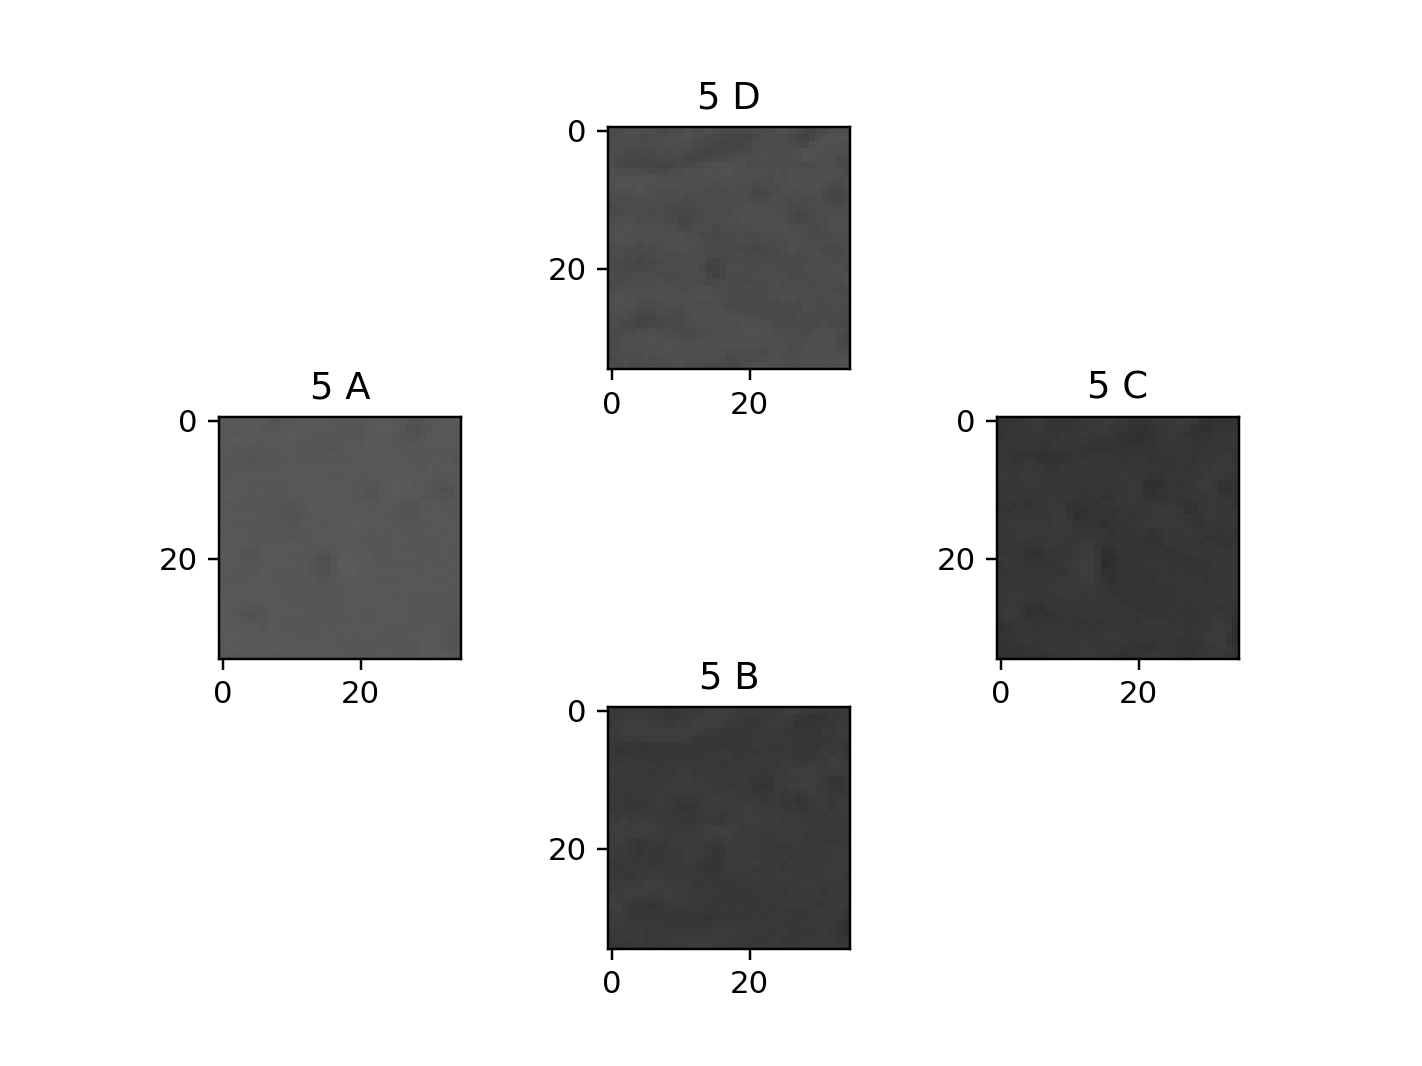

for segment  6
nx= 36
ny= 36
0 1 31.04503857548611
0 2 23.887066503104144
0 3 54.824093897613345
1 2 48.120594068195935
1 3 -1.7199764517085756
2 3 33.38338607859756
Correlation score = 89.29203769942028



<IPython.core.display.Javascript object>


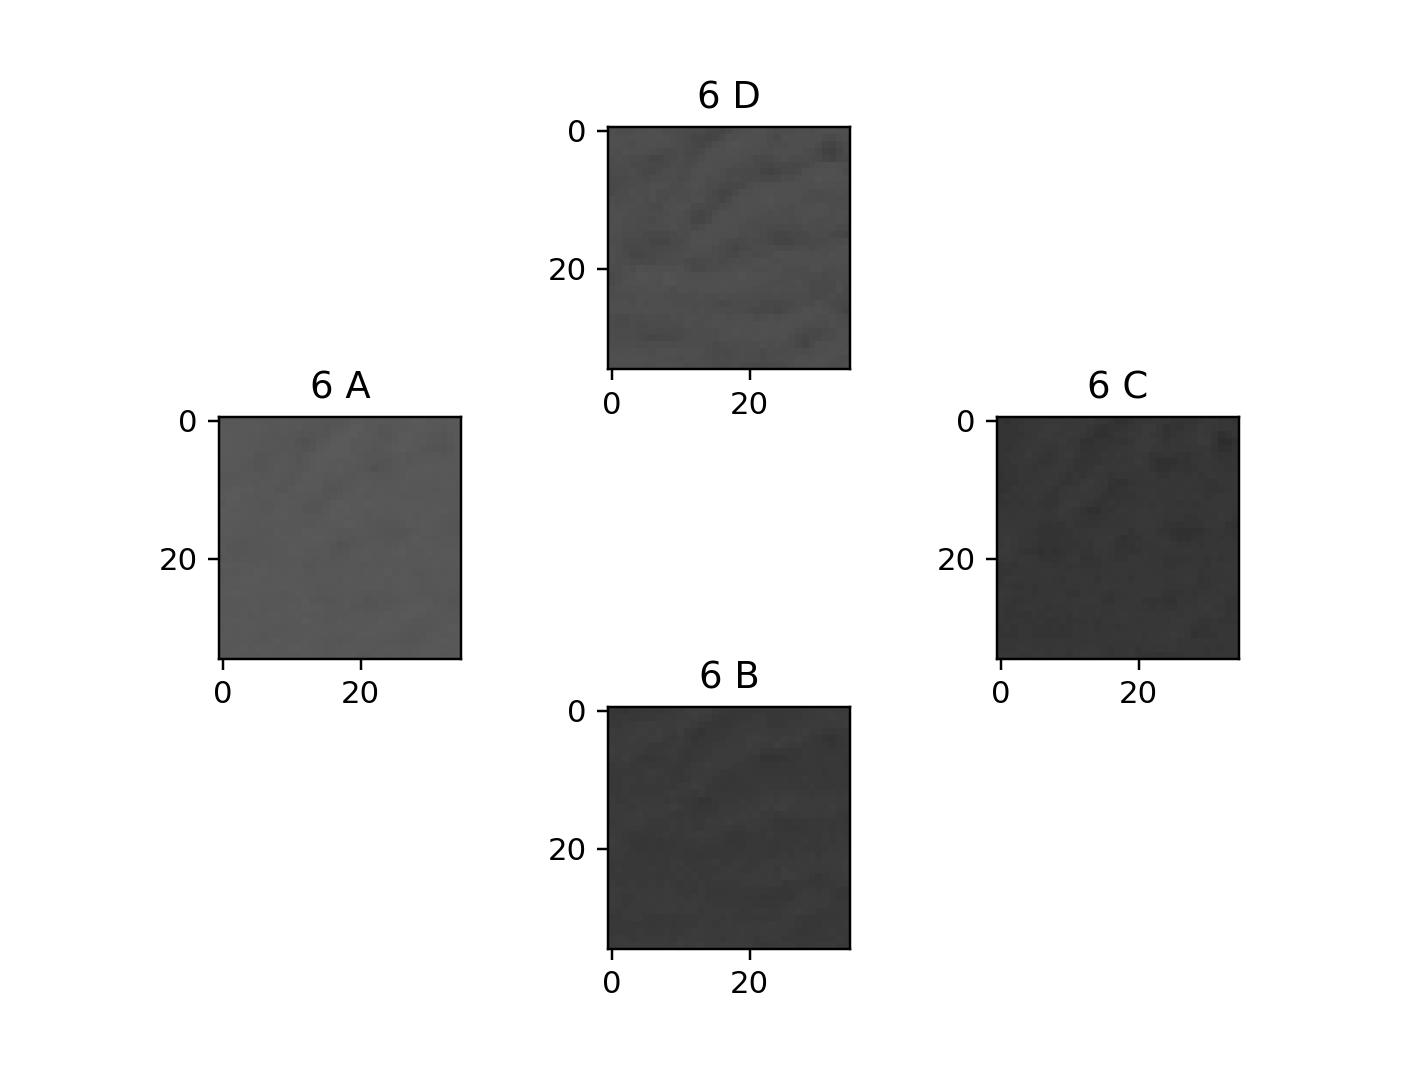

for segment  7
nx= 36
ny= 36
0 1 30.362844472215357
0 2 2.298837971127381
0 3 25.777480956710836
1 2 18.67621337091948
1 3 -0.470640730503445
2 3 38.608620493097995
Correlation score = 58.57741484470284



<IPython.core.display.Javascript object>


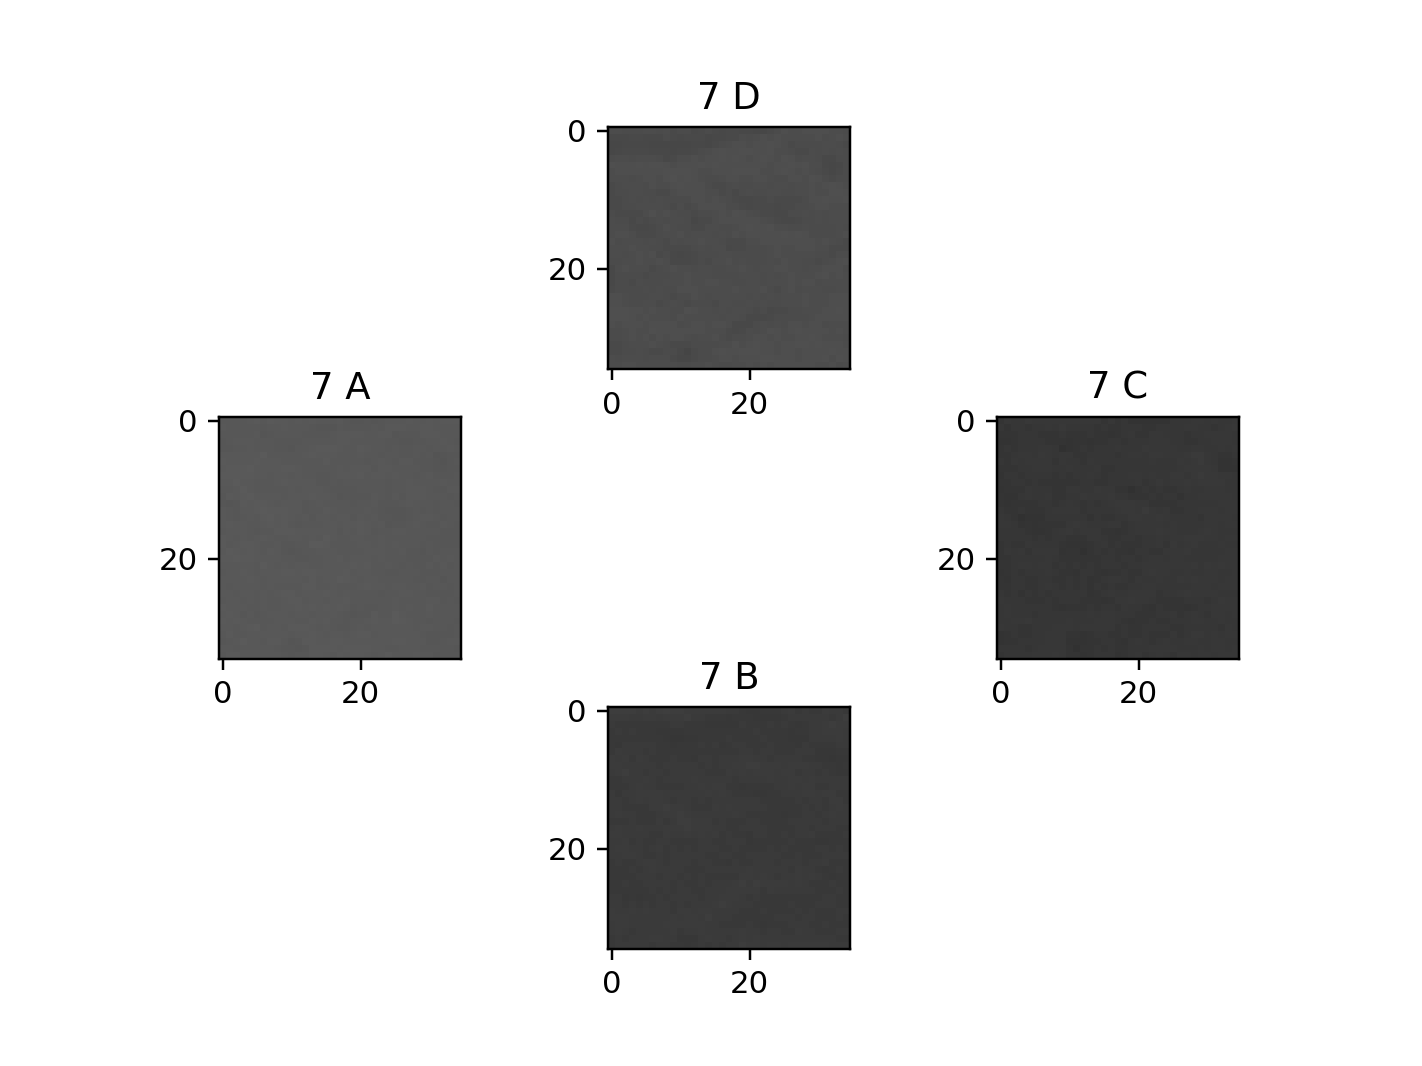

for segment  8
nx= 36
ny= 36
0 1 26.4682458695226
0 2 -12.985703564676477
0 3 33.170756118187995
1 2 32.71254650058349
1 3 -29.16425956268569
2 3 35.48160412521425
Correlation score = 71.7572613999616



<IPython.core.display.Javascript object>


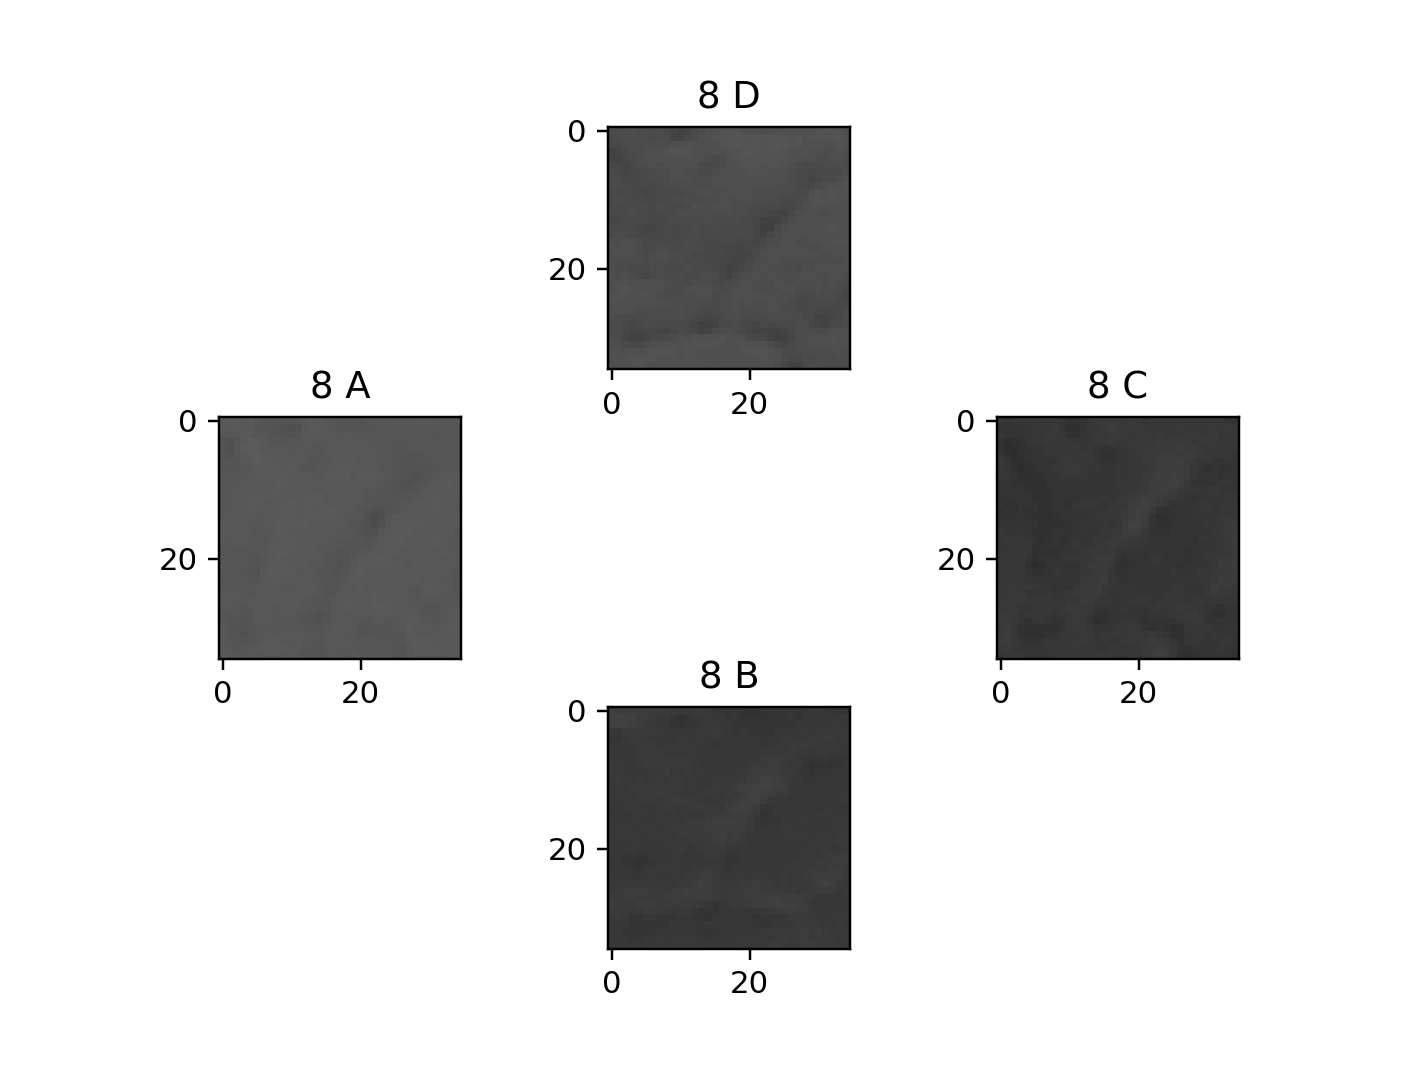

for segment  9
nx= 36
ny= 36
0 1 33.61217142334262
0 2 6.450135279070757
0 3 40.49080067909295
1 2 41.26792246971283
1 3 -10.72572602146443
2 3 35.85518544336747
Correlation score = 76.90620390694458



<IPython.core.display.Javascript object>


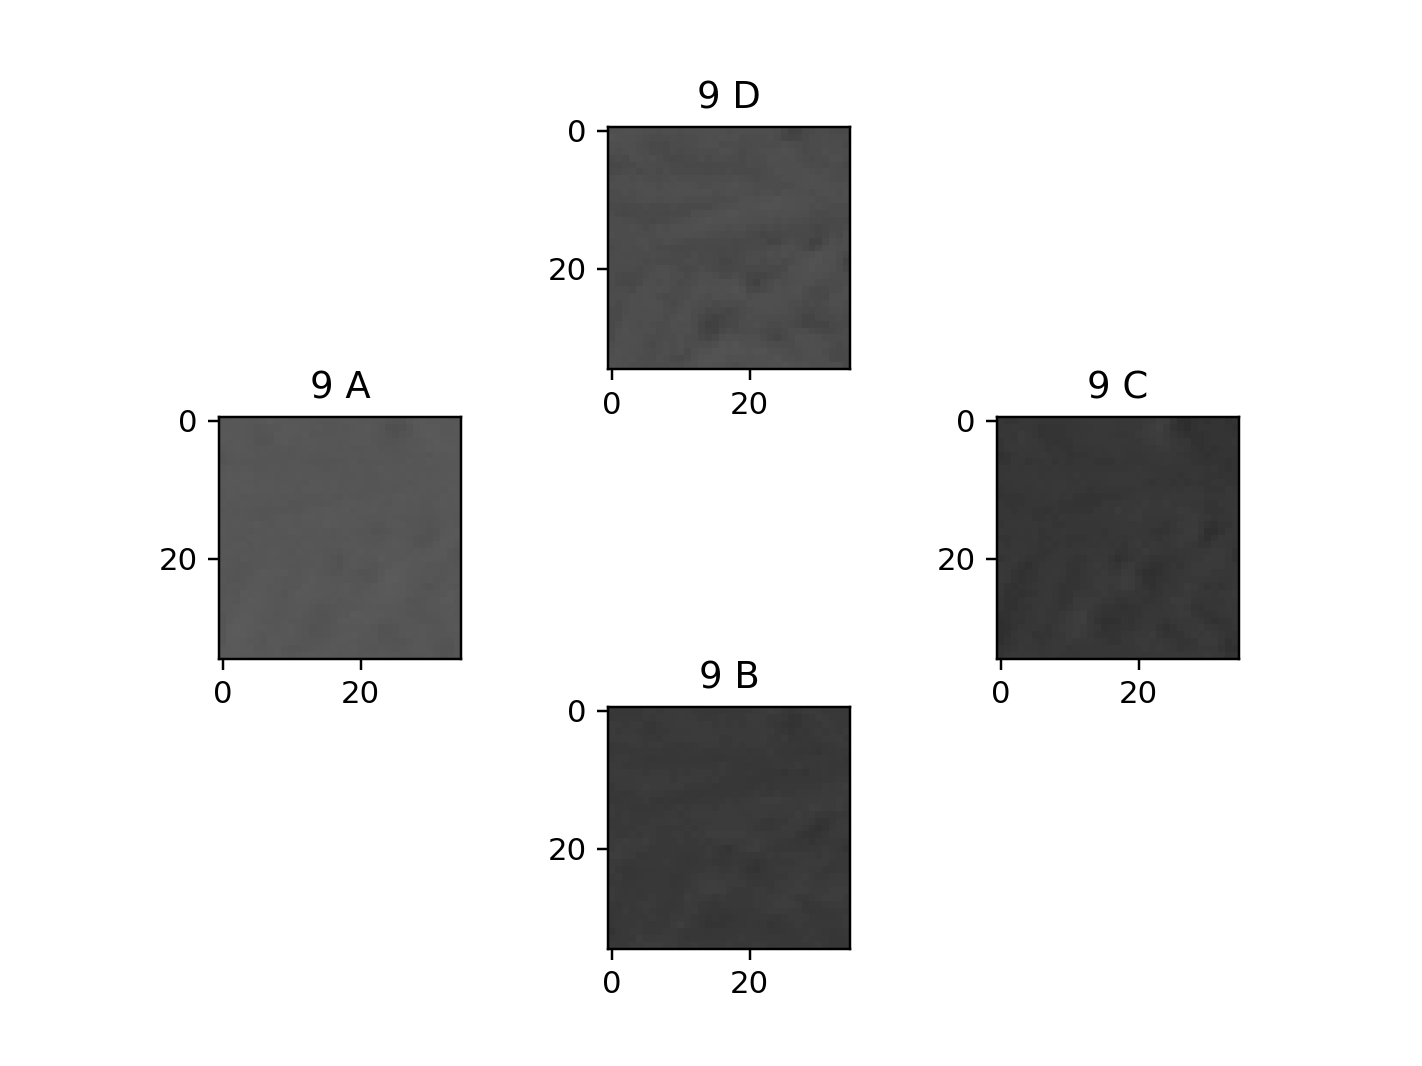

for segment  10
nx= 36
ny= 36
0 1 34.29110758162469
0 2 33.22252799719656
0 3 51.10463132103348
1 2 49.246978718145414
1 3 -5.305843389035123
2 3 40.14935354771478
Correlation score = 94.63977623278521



<IPython.core.display.Javascript object>


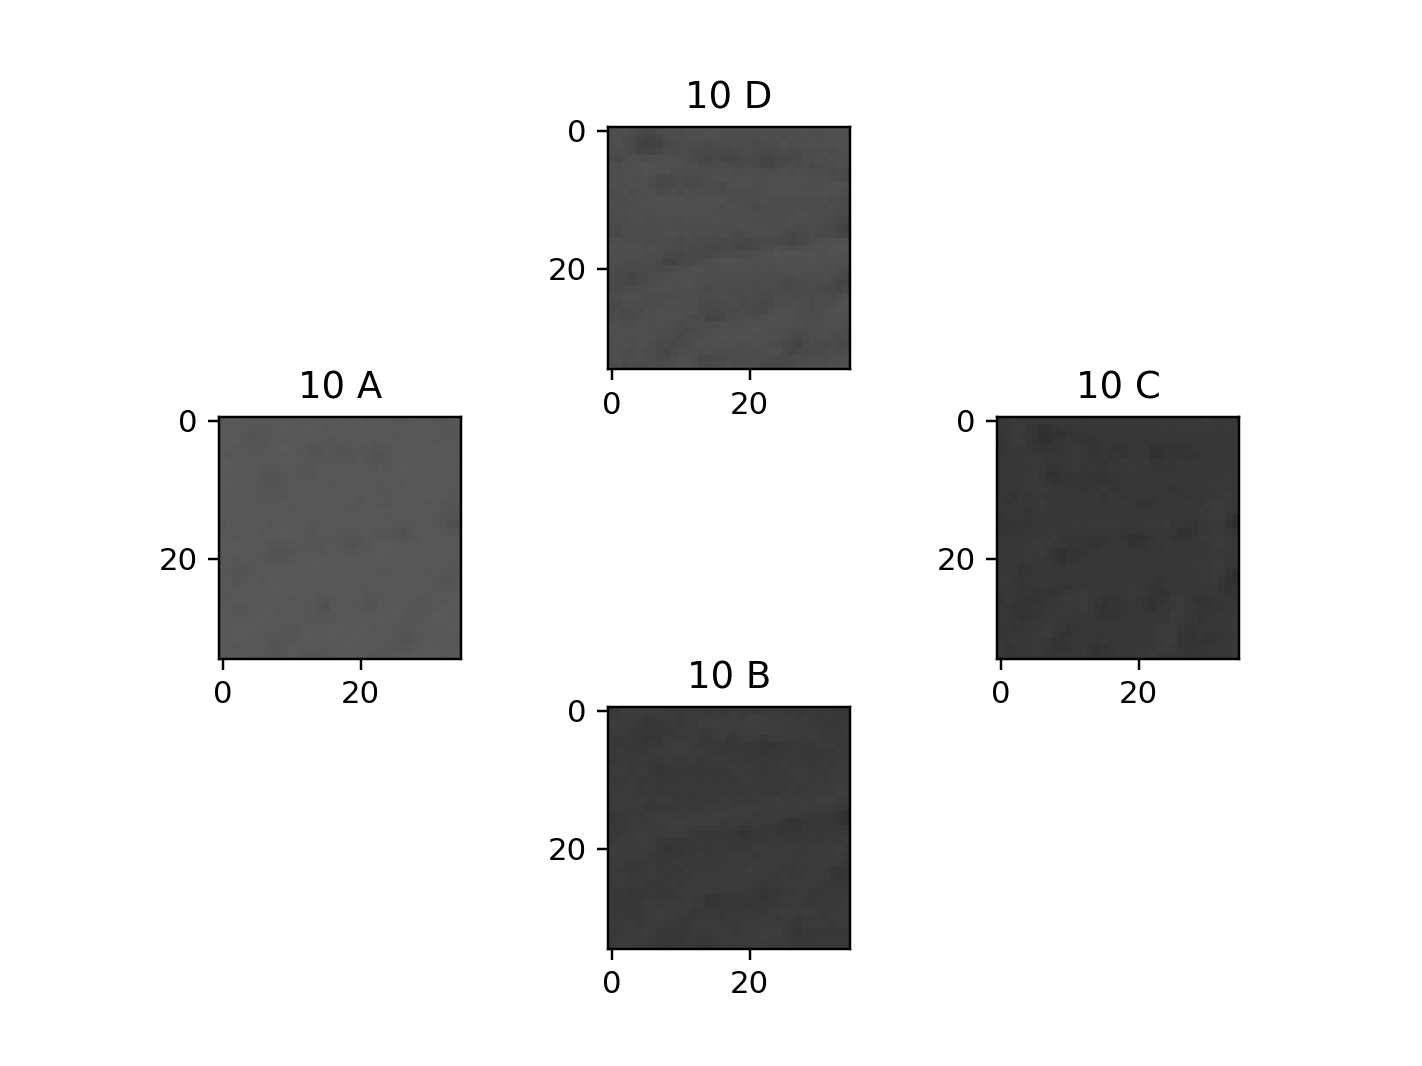

for segment  11
nx= 36
ny= 36
0 1 28.505437769491333
0 2 13.724253493060978
0 3 35.453738214916825
1 2 30.22668206773456
1 3 -0.8607168846161348
2 3 40.79868993221576
Correlation score = 69.54717041223492



<IPython.core.display.Javascript object>


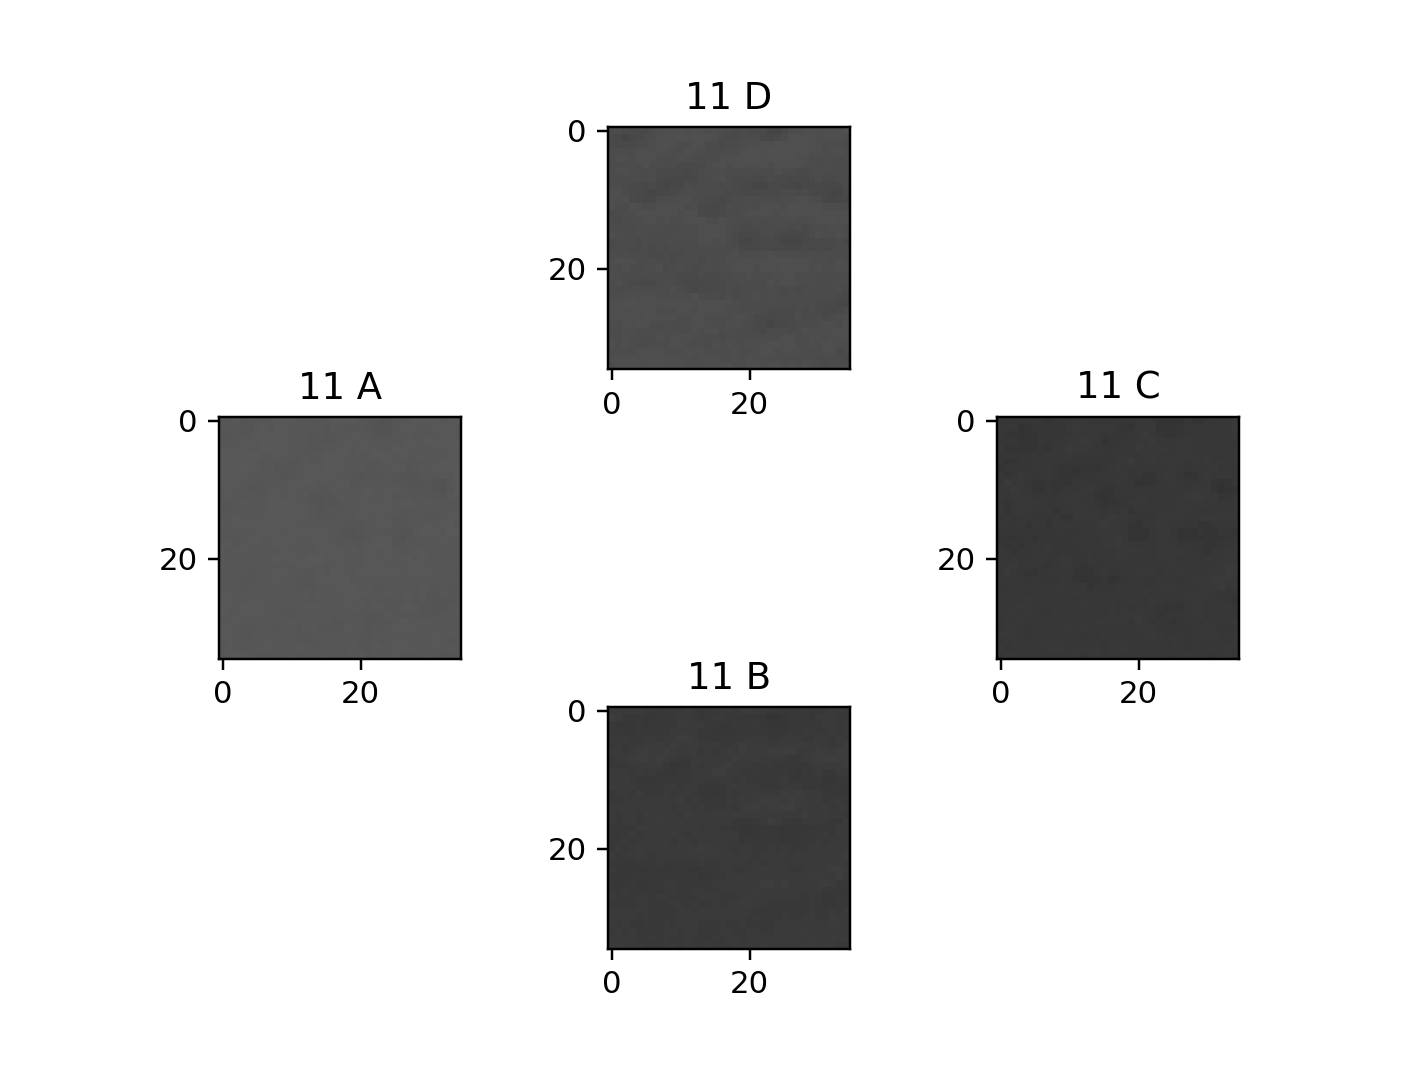

for segment  12
nx= 36
ny= 36
0 1 32.60362782274853
0 2 -33.491741125524335
0 3 24.292801527360524
1 2 21.586769348690144
1 3 -26.86751003502024
2 3 36.34168375036648
Correlation score = 72.68702195769394



<IPython.core.display.Javascript object>


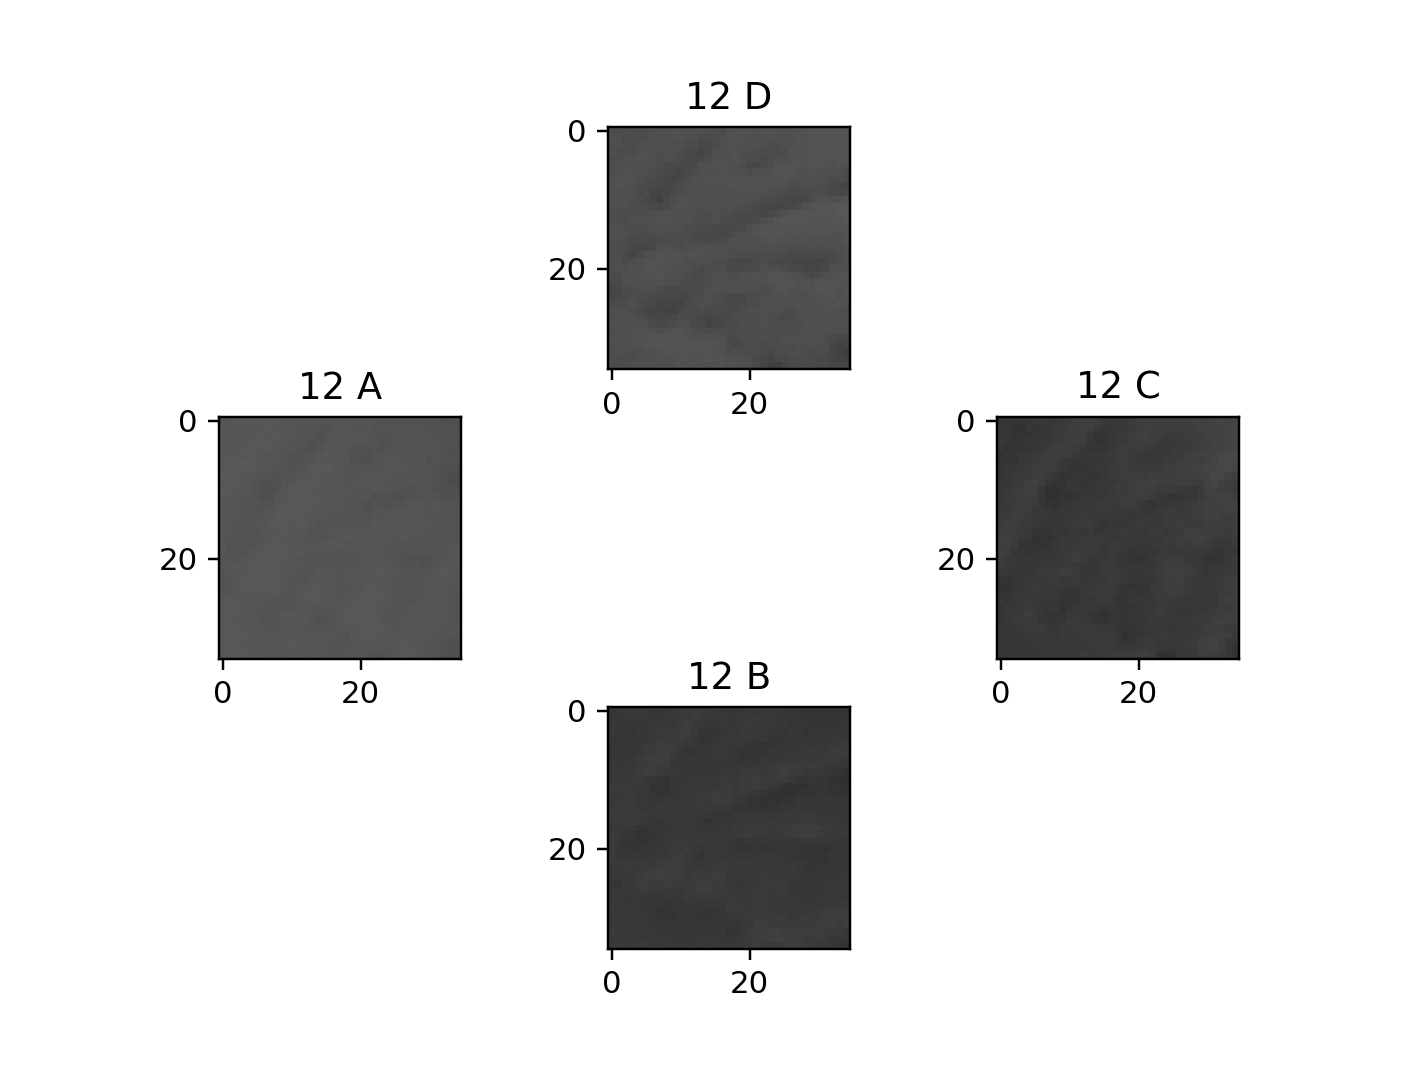

for segment  13
nx= 36
ny= 36
0 1 39.72607806642173
0 2 -10.330415708706239
0 3 29.205709917702737
1 2 29.645300743728626
1 3 -13.106999129242894
2 3 40.59905555212777
Correlation score = 72.36555018194754



<IPython.core.display.Javascript object>


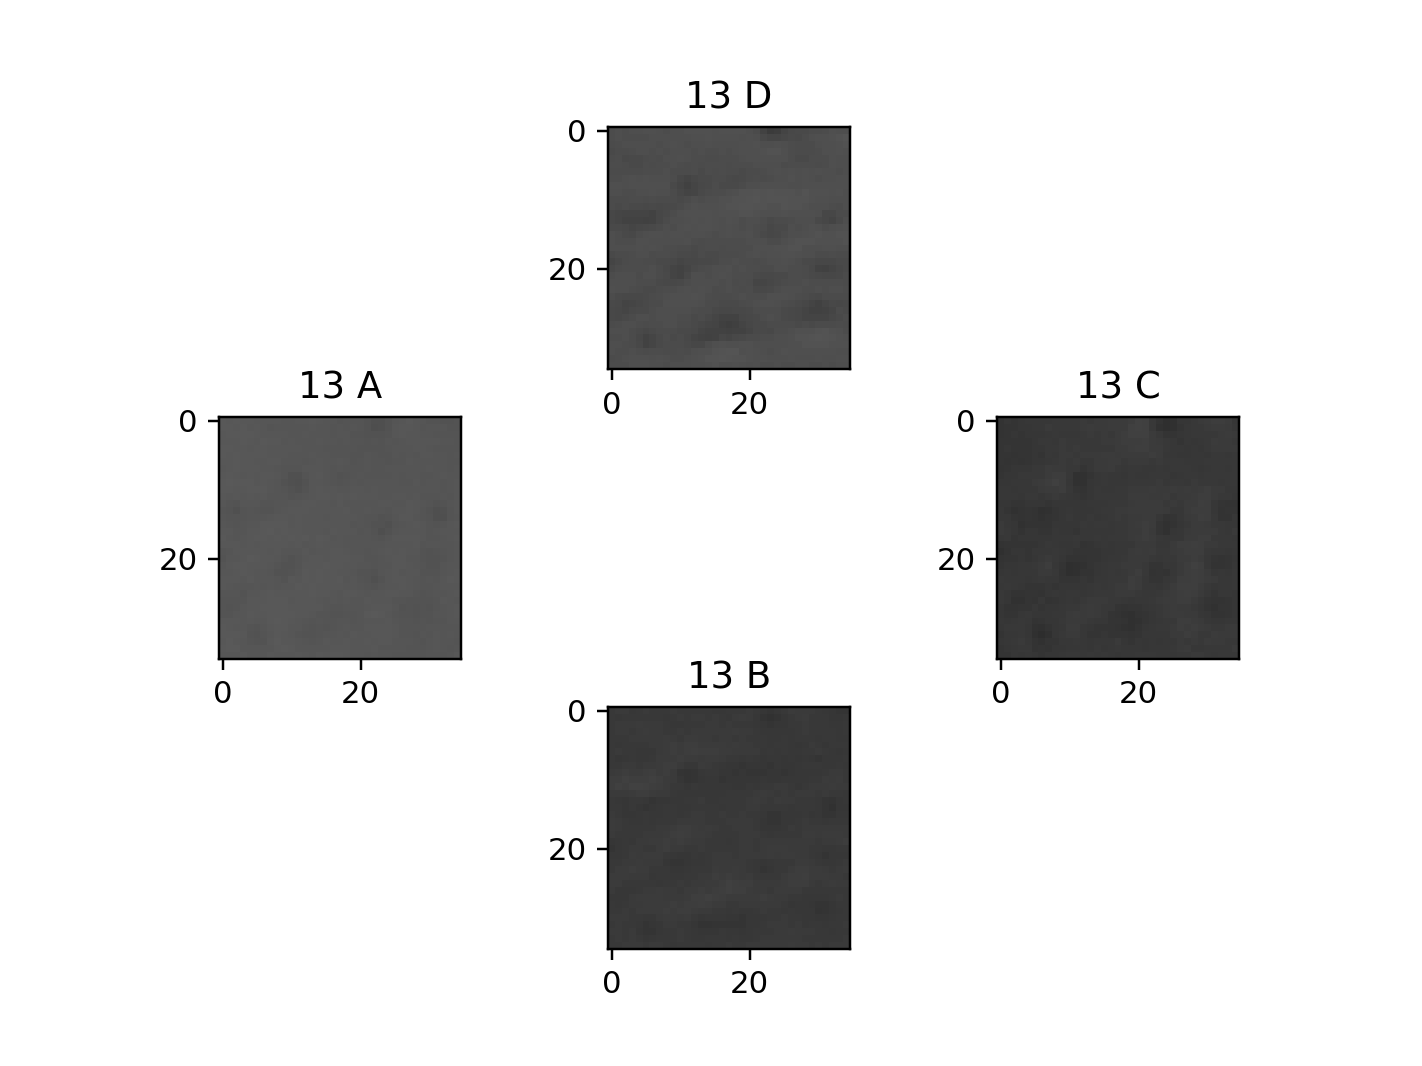

for segment  14
nx= 36
ny= 36
0 1 17.962812084060616
0 2 4.715613614817912
0 3 38.891741427993026
1 2 35.94669393498067
1 3 -14.353026131058266
2 3 29.403637422812434
Correlation score = 64.96318371739206



<IPython.core.display.Javascript object>


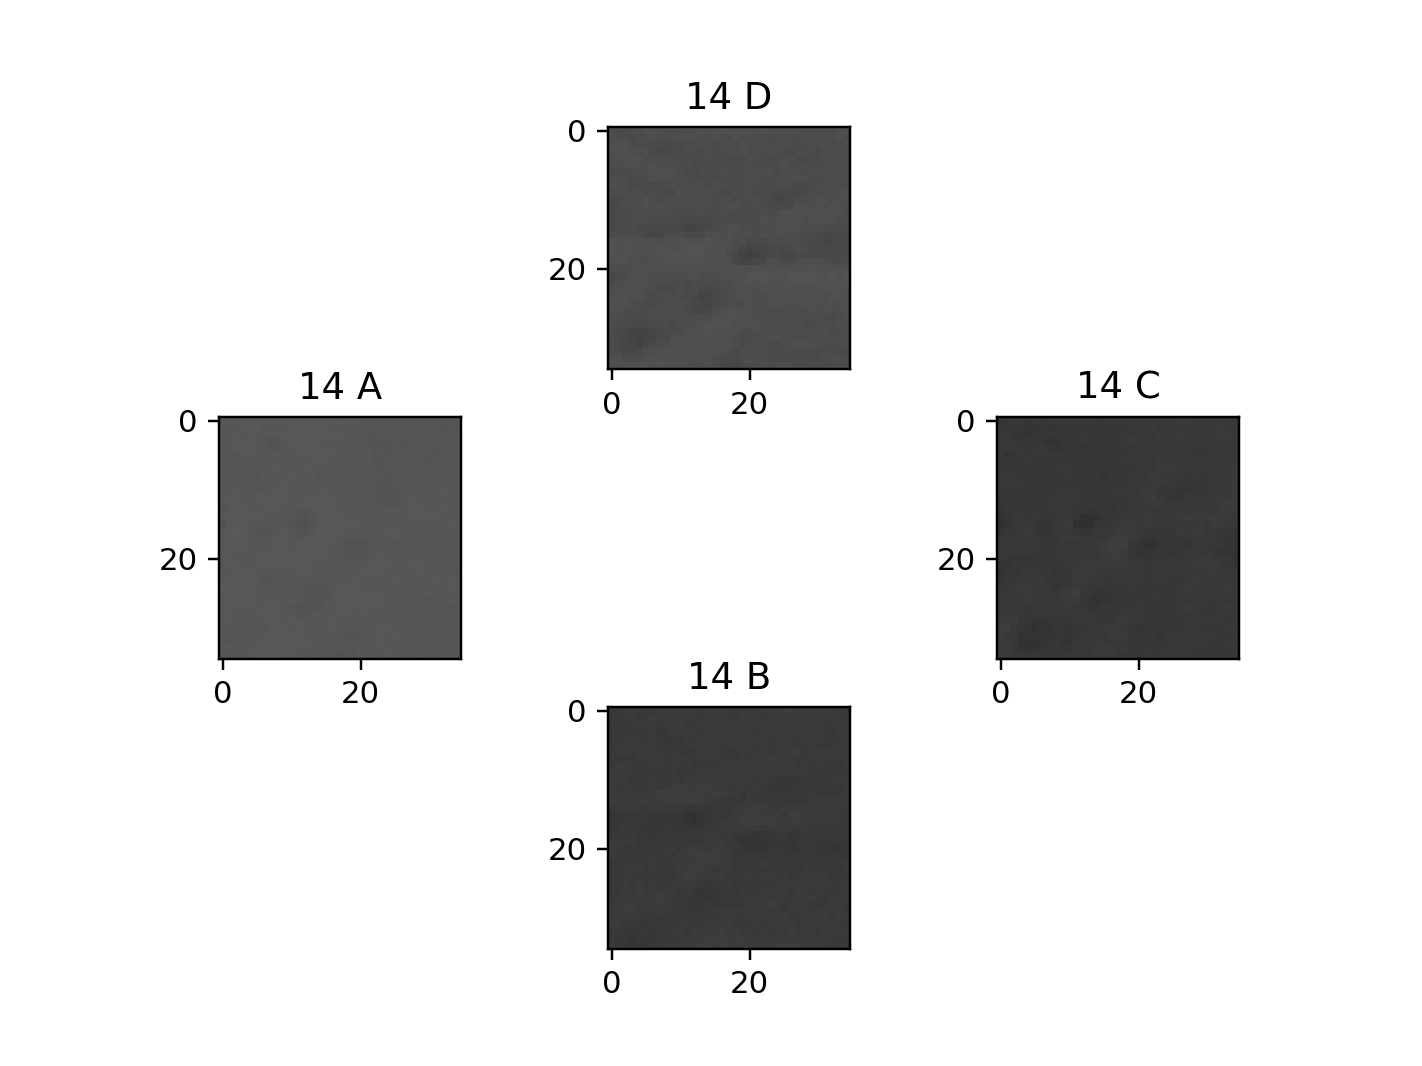

for segment  15
nx= 36
ny= 36
0 1 27.945599432250862
0 2 2.8091738614503585
0 3 36.41769420959833
1 2 22.69336253386318
1 3 -11.752737758131639
2 3 47.23012134015934
Correlation score = 70.70287368039874



<IPython.core.display.Javascript object>


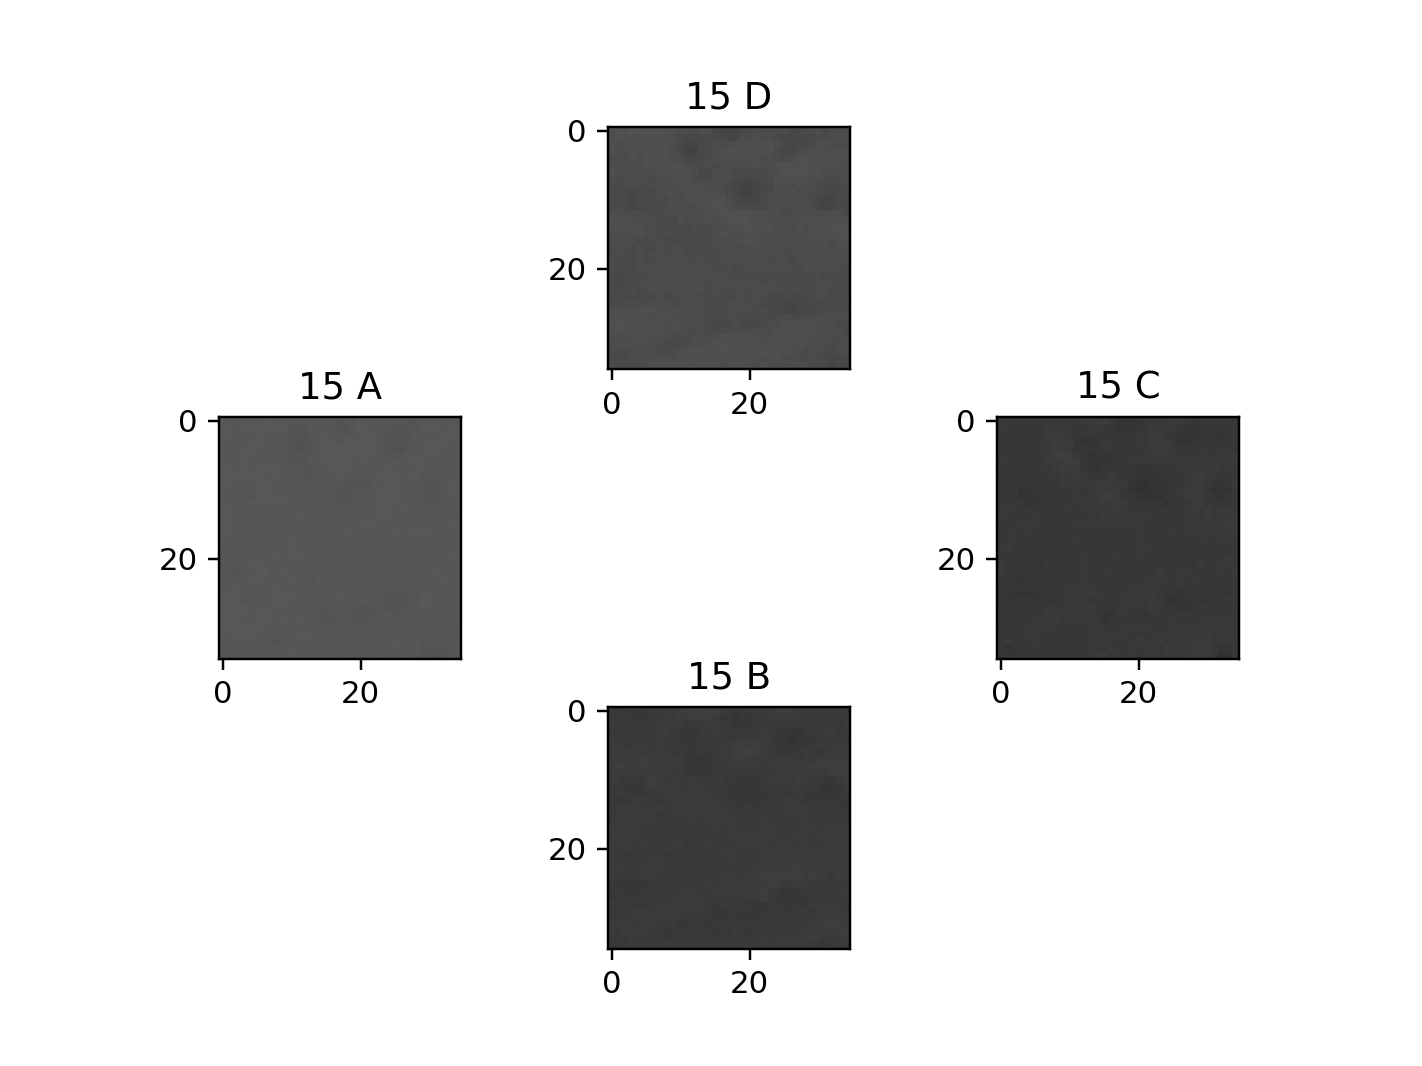

<IPython.core.display.Javascript object>


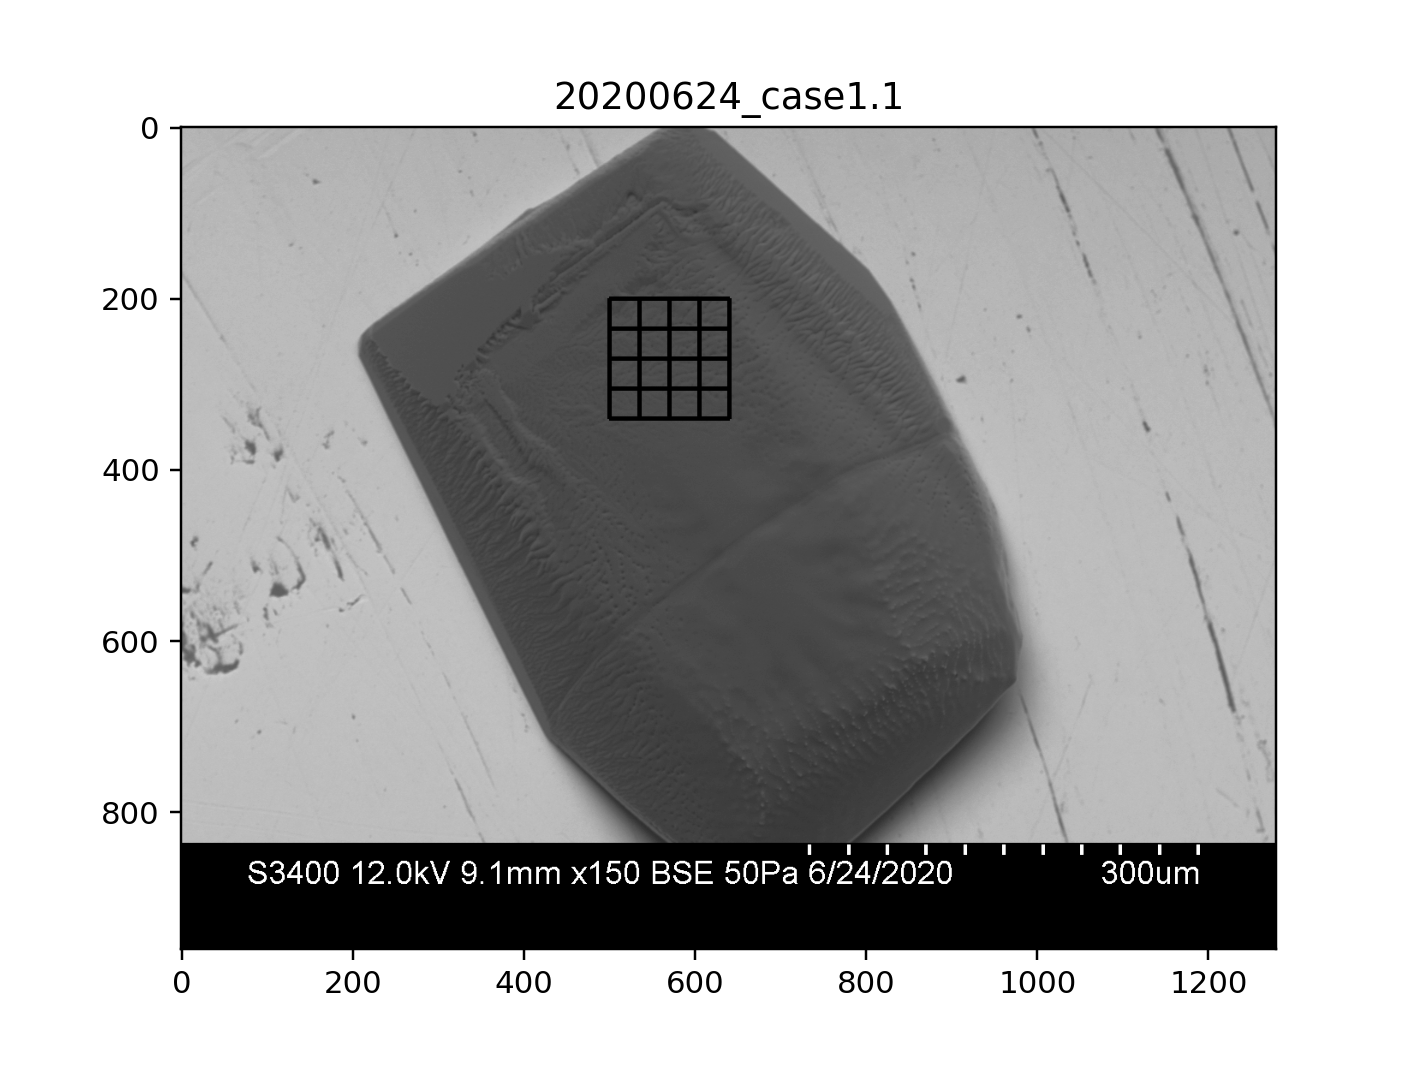

In [46]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [47]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

../case1.0 (calibration)/Calibration.nml


In [48]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [49]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [50]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [51]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [52]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [53]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [54]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 16 )
for 500 200
Observed intensities (detector B):
mean, max, min = 46.24 52.0 40.0
<diff>, std(diff), di2 = -13.400255760393636 6.222528376702392 1354.5759939213685
<diff>, std(diff), di2 = -13.42806448213876 5.649850351027694 14.833679948530557
<diff>, std(diff), di2 = -13.390217562408074 5.73352462781297 0.36450103089131336

Segment: 1 ( 2 of 16 )
for 500 235
Observed intensities (detector B):
mean, max, min = 46.57877551020408 52.0 42.0
<diff>, std(diff), di2 = -13.243929229781388 6.050625406589044 1014.6880156743816
<diff>, std(diff), di2 = -13.289824238808274 5.556596569825134 12.144716384637453
<diff>, std(diff), di2 = -13.251338053398861 5.643510594807885 0.2939972737474714
Noverlap = 36

Segment: 2 ( 3 of 16 )
for 500 270
Observed intensities (detector B):
mean, max, min = 46.46448979591837 51.0 42.0
<diff>, std(diff), di2 = -12.93658229100588 6.392868920800469 1140.9136990780933
<diff>, std(diff), di2 = -13.152987132813607 5.493297044852805 15.570174517026

140
140


<IPython.core.display.Javascript object>


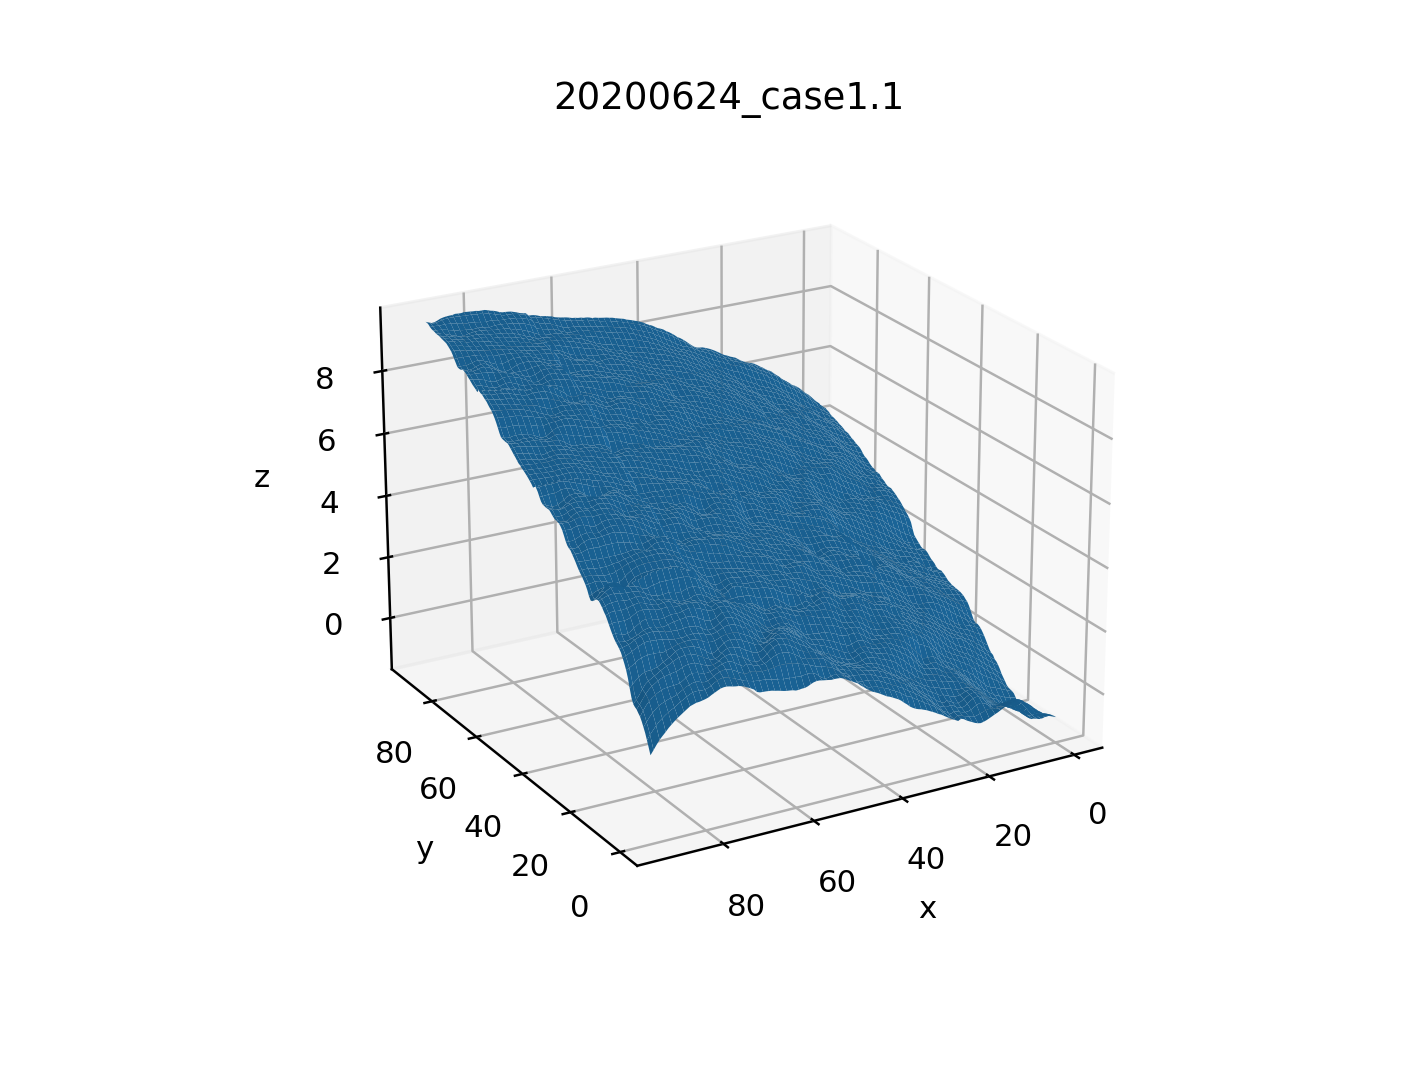

In [55]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [26]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments1_retrieved
